## Spike Prior

In this notebook we see how well the NN with dropout performs on a spike at 0, then a gaussian with s.d 1 centred at x = 5

In [14]:
import sys, pathlib, os

from SummaryStatisticNN.MainCode.generate_data import make_spike_simulator

CODE_DIR = pathlib.Path(os.getcwd())  / "MainCode"
if CODE_DIR.exists():
    sys.path.append(str(CODE_DIR.resolve()))
else:
    raise FileNotFoundError("Code directory not found")

# Module imports
from generate_data import make_spike_simulator, make_dataset
from NN import NN, GatedNN, ThetaOnly
from custom_loss import gated_loss
from plotting_functions.plot_single_dataset_posterior import make_posterior_plotter
from plotting_functions.plot_training_loss import plot_loss
from performance_metrics.average_relative_error import make_avg_rel_error_fn


# External imports
from tensorflow.keras.callbacks import EarlyStopping

print("successfully imported all modules")


successfully imported all modules


In [15]:
no_params = 10
epochs = 200
patience_early_stopping = 10
no_examples = 20_000
batch_size = 128

sim_cfg = dict(
    zero_prob = 0.3,
    no_params     = no_params,
    n_per_sample  = 1000,
    noise_std     = 0.2,
    batch_size = batch_size
)

NN_cfg = dict(
    no_params = no_params,
    neurons = [128, 128],
    dropout_probs =  [0.2, 0.2],
    always_on_dropout = True
)

### Generate data

In [16]:
spike_simulator = make_spike_simulator(5,1, **sim_cfg)
spike_train = make_dataset(int(0.9*no_examples), spike_simulator, sim_cfg["batch_size"])
spike_val = make_dataset(int(0.1*no_examples), spike_simulator, sim_cfg["batch_size"])

### NN for spike

In [17]:
spike_NN = NN(**NN_cfg)
spike_NN.norm.adapt(spike_train.map(lambda x, y: x))
spike_NN.compile(loss='mse', optimizer="adam")

2025-06-27 13:12:17.707727: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Fit NN

Epoch 1/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.7251 - val_loss: 2.8109
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2506 - val_loss: 1.3758
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3160 - val_loss: 1.0920
Epoch 4/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0422 - val_loss: 0.9106
Epoch 5/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9059 - val_loss: 0.8815
Epoch 6/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8414 - val_loss: 0.7995
Epoch 7/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7886 - val_loss: 0.7648
Epoch 8/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7563 - val_loss: 0.7361
Epoch 9/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7191 - val_loss: 0.7122
Epoch 10/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6984 - val_loss: 0.6910
Epoch 11/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6648 - val_loss: 0.6648
Epoch 12/200
140/140 ━━━━━━━━━━━━━━━━━━━━

Model: "NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_norm (Normalization)      │ (None, 121)            │           243 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,499 (392.58 KB)

 Trainable params: 33,418 (130.54 KB)

 Non-trainable params: 243 (976.00 B)

 Optimizer params: 66,838 (261.09 KB)

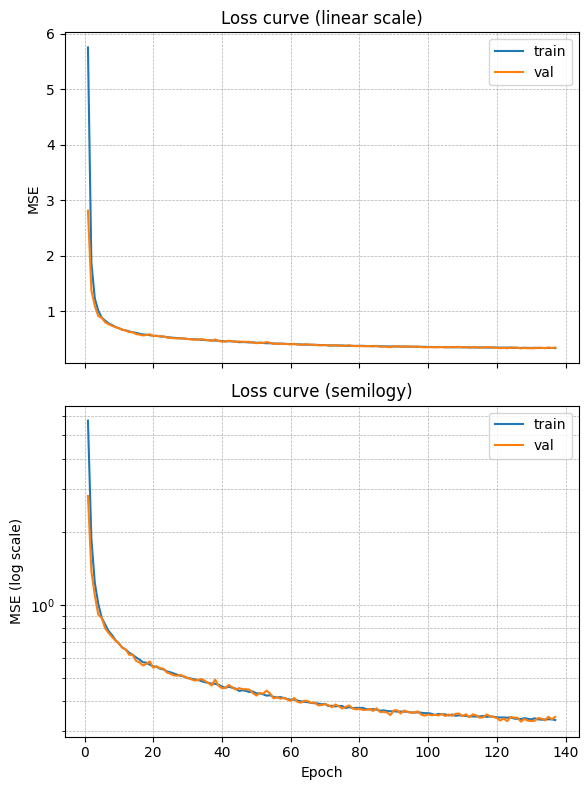

In [18]:
history = spike_NN.fit(
    spike_train.batch(batch_size),
    validation_data=spike_val.batch(batch_size),
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience_early_stopping,
                             restore_best_weights=True)]
)
spike_NN.summary()
plot_loss(history)

In [19]:
spike_avg_rel_error = make_avg_rel_error_fn(spike_simulator,
                                              batchsize   = batch_size,
                                              no_tests    = 2_000,
                                              mc_samples  = 30)

In [20]:
e_spike = spike_avg_rel_error(model=spike_NN)
print(f"spike test error : {e_spike:.4f}")

spike test error : 0.0589


In [21]:
spike_plot = make_posterior_plotter(
    simulate_batch=spike_simulator,
    no_params=no_params,
    mc_samples=10_000,
    bins=40,
    show_mc_stats=True,
    xlim = [-2,7]
)

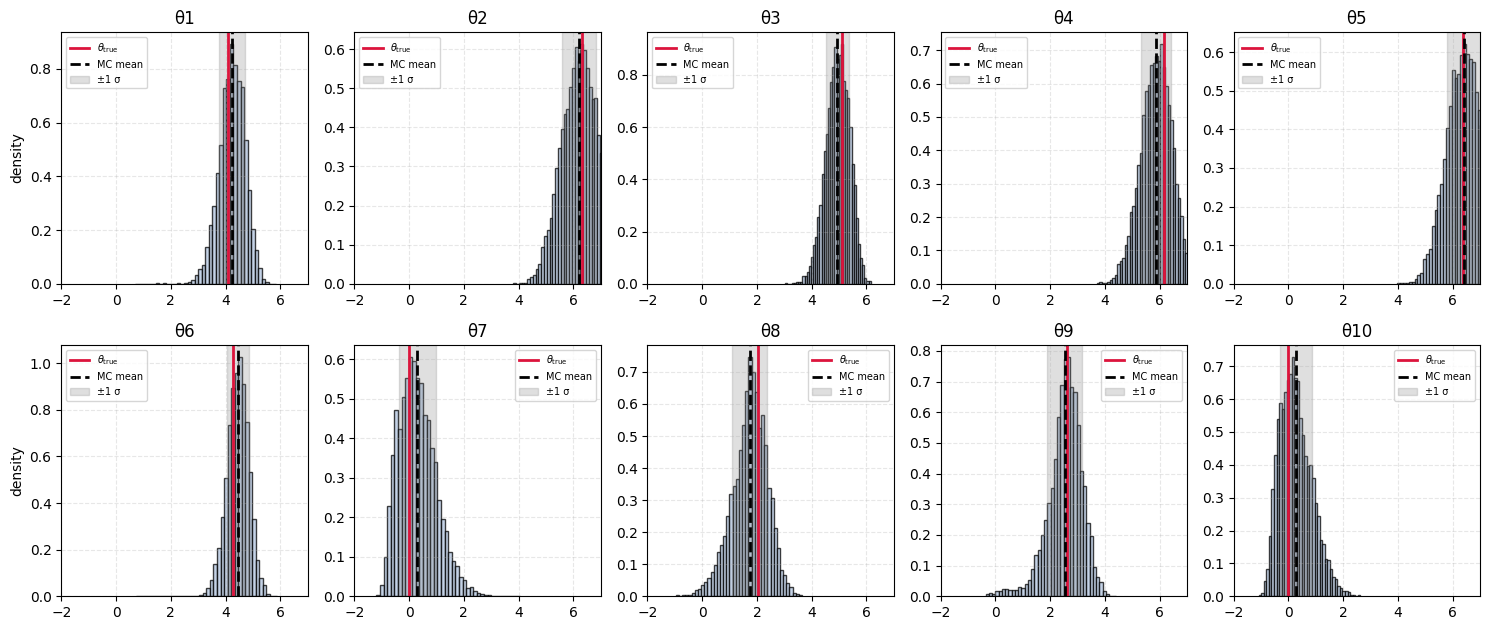

In [22]:
spike_plot(model=spike_NN)

### Try again with our new Gated NN and compare the results

In [23]:
spike_gated_NN = GatedNN(**NN_cfg)
spike_gated_NN.norm.adapt(spike_train.map(lambda x, y: x))
spike_gated_NN.compile(loss=gated_loss, optimizer="adam")

Epoch 1/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.0534 - val_loss: 3.1945
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5017 - val_loss: 1.5152
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3657 - val_loss: 1.0535
Epoch 4/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0136 - val_loss: 0.8974
Epoch 5/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8516 - val_loss: 0.7673
Epoch 6/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7487 - val_loss: 0.7013
Epoch 7/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6981 - val_loss: 0.6465
Epoch 8/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6481 - val_loss: 0.6257
Epoch 9/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6051 - val_loss: 0.5672
Epoch 10/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5733 - val_loss: 0.5711
Epoch 11/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5478 - val_loss: 0.5386
Epoch 12/200
140/140 ━━━━━━━━━━━━━━━━━━━

Model: "GatedNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_norm (Normalization)      │ (None, 121)            │           243 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gate (Dense)                    │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ value (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,369 (407.70 KB)

 Trainable params: 34,708 (135.58 KB)

 Non-trainable params: 243 (976.00 B)

 Optimizer params: 69,418 (271.17 KB)

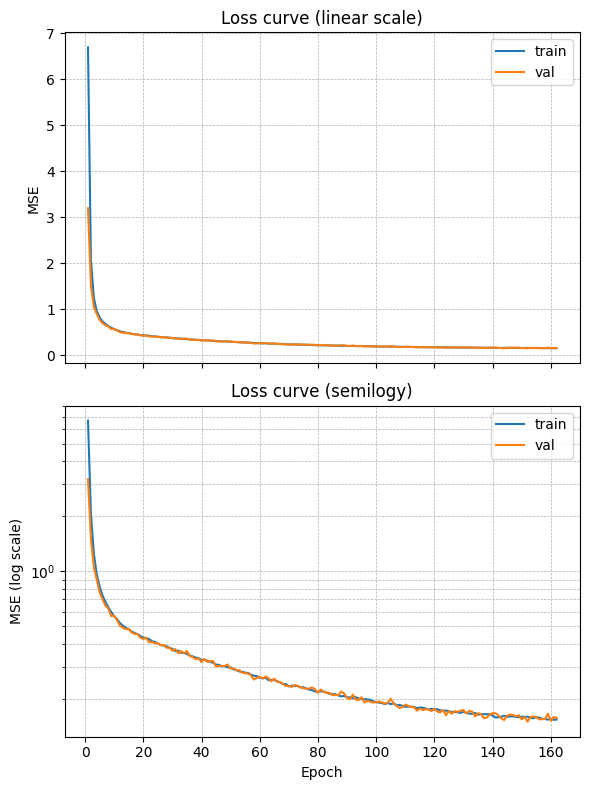

In [24]:
gated_history = spike_gated_NN.fit(
    spike_train.batch(batch_size),
    validation_data=spike_val.batch(batch_size),
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience_early_stopping,
                             restore_best_weights=True)]
)
spike_gated_NN.summary()
plot_loss(gated_history)

In [25]:
theta_only_model = ThetaOnly(spike_gated_NN)
e_gated_spike = spike_avg_rel_error(model=theta_only_model)
print(f"spike test error : {e_gated_spike:.4f}")

spike test error : 0.0498


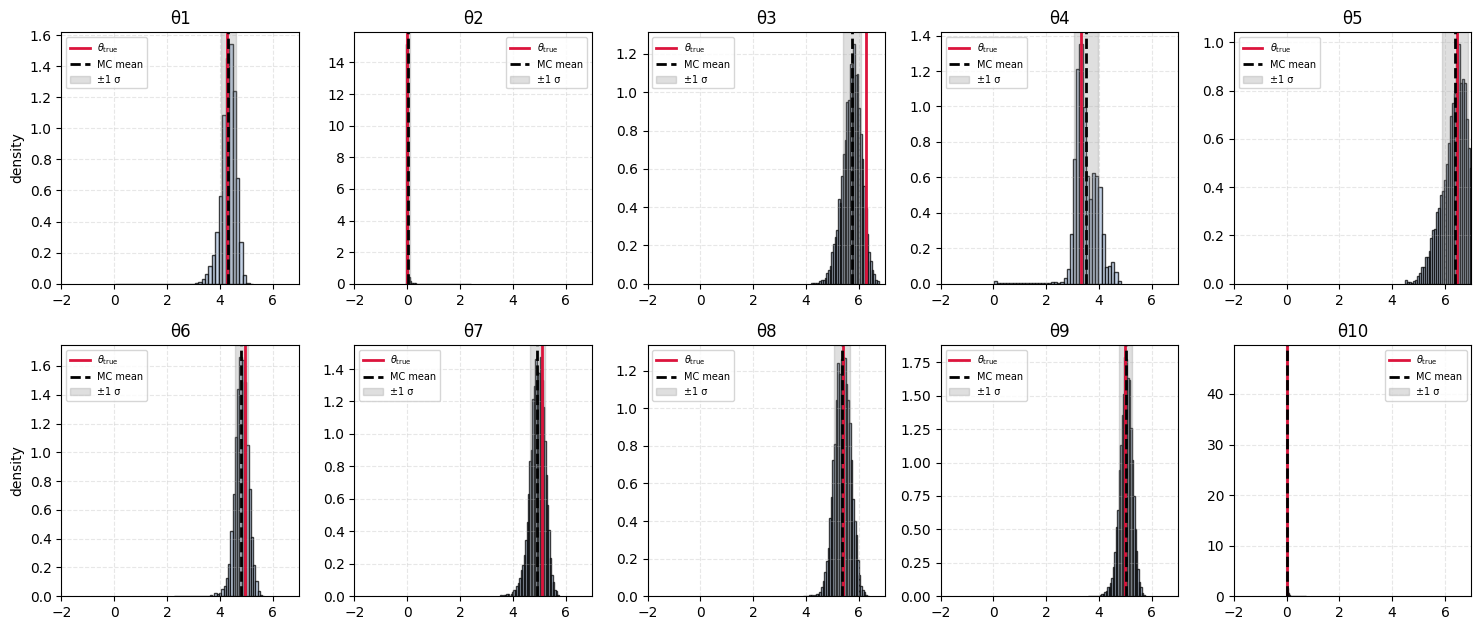

In [27]:
spike_plot(model=theta_only_model)